# 数据读取
读取csv数据，初次得到的数据结构如下：
```
data=
[
    {
        'date',
        'time',
        'data':[
            第road_id行，存放road_id的数据：[status,speed]
        ]
        不同时间的不同data不等长
    }
]
```

In [1]:
import csv
import os
file_path='data'
file_list=sorted(os.listdir(file_path))
date_time={}
for fname in file_list:
    if fname[0]=='.':
        continue
        
    date=fname[8:13]
    time=fname[14:22]
    
    if date>='10-02' and date<='10-31':
        if date not in date_time:
            date_time[date]=[time]
        else:
            date_time[date].append(time)
#把每一天的时间段数据归一化，抛弃尾端数据
min_time_num=216
for date,times in date_time.items():
    if len(times)<min_time_num:
        min_time_num=len(times)
for date in date_time:
    if len(date_time[date])>min_time_num:
        date_time[date]=date_time[date][0:min_time_num]

road_dict={}
data=[]

for date,times in date_time.items():
    for time in times:
        fname='ts_2021-'+date+' '+time+'.csv'
        date_data=[[0,0] for i in range(len(road_dict))]
        with open(file_path+'/'+fname,'r') as f:
            csv_reader = csv.reader(f)
            for row in csv_reader:
                if (row[0],row[2]) in road_dict:
                    date_data[road_dict[(row[0],row[2])]['id']][0]=int(row[1])
                    date_data[road_dict[(row[0],row[2])]['id']][1]=int(row[4])
                else:
                    road_dict[(row[0],row[2])]={'id':len(road_dict)}
                    date_data.append([int(row[1]),int(row[4])])
            f.close()
        #time=(int(fname[14:16])-5)*60+int(fname[17:19])
        data.append({'date':date,'time':time,'data':date_data})

查询道路的坐标

In [2]:
import requests
from fake_useragent import UserAgent
import json
import threading
import queue
import time
q = queue.Queue()
thread_list = []

def road_geomsg(road):
    road_location=(0.0,0.0)
    #爬取道路中心点
    server_host='https://restapi.amap.com/v3/geocode/geo'
    parameters={
        'key':'111d1e3797ffa20c7d44a42ab0bed3fd',
        'city':'上海市',
        'address':road
    }
    response=requests.get(url=server_host,
                         headers={'User-Agent':UserAgent(path='fakeuseragent.json').random},
                         params=parameters)
    response.encoding=response.apparent_encoding
    res=json.loads(response.text)
    if len(res['geocodes'])>0:
        location=res['geocodes'][0]['location'].split(',')
        road_location=(float(location[0]),float(location[1]))
        
    #爬取道路polyline
    server_host='https://restapi.amap.com/v3/traffic/status/road'
    parameters={
        'key':'111d1e3797ffa20c7d44a42ab0bed3fd',
        'city':'上海市',
        'name':road,
        'level':5,
        'extensions':'all'
    }
    response=requests.get(url=server_host,
                         headers={'User-Agent':UserAgent(path='fakeuseragent.json').random},
                         params=parameters)
    response.encoding=response.apparent_encoding
    res=json.loads(response.text)
    if 'trafficinfo' in res and 'roads' in res['trafficinfo']:
        for road_msg in res['trafficinfo']['roads']:
            if 'polyline' in road_msg:
                polyline=road_msg['polyline'].split(';')
                polyline=[(float(loc.split(',')[0]),float(loc.split(',')[1])) for loc in polyline]
                q.put({'road':road,'direction':road_msg['direction'],'location':road_location,'polyline':polyline})
    else:
        print(res)
            
road_names=[]
for road in road_dict:
    if road[0] not in road_names:
        road_names.append(road[0])

for name in road_names:
    thread=threading.Thread(target=road_geomsg, args=(name,))
    thread_list.append(thread)
    thread.start()
    time.sleep(0.1)
    
for thread in thread_list:
    thread.join()
thread_list.clear()

while not q.empty():
    msg=q.get()
    if (msg['road'],msg['direction']) in road_dict:
        road_dict[(msg['road'],msg['direction'])]['location']=msg['location']
        road_dict[(msg['road'],msg['direction'])]['polyline']=msg['polyline']

{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}
{'status': '0', 'info': 'UNKNOWN_ERROR', 'infocode': '20003'}


查询上海市行政区边界polyline

In [3]:
import numpy as np
server_host='https://restapi.amap.com/v3/config/district'
parameters={
    'key':'111d1e3797ffa20c7d44a42ab0bed3fd',
    'keywords':'上海市',
    'subdistrict':0,
    'extensions':'all'
}
response=requests.get(url=server_host,
                     headers={'User-Agent':UserAgent(path='fakeuseragent.json').random},
                     params=parameters)
response.encoding=response.apparent_encoding
res=json.loads(response.text)
poly_lines=res['districts'][0]['polyline'].split('|')
poly_lines=[line.split(';') for line in poly_lines]
for i in range(len(poly_lines)):
    poly_lines[i]=np.array([point.split(',') for point in poly_lines[i]],dtype=float).T
sh_poly_lines=poly_lines

# 数据清洗
二次处理读到的csv数据，使其转化为光栅(Raster)数据
```
dataset=[
    for each day
    [
        for each roads
        [
            for each time
            [
                [status,speed]
            ]
        ]
    ]
]
```
记每天为一个样本组，天数=样本数=N，每个样本记录了E个道路信息，每个道路包含T个时间片的监测数据，每个数据有C个特征

In [4]:
import numpy as np
from collections import Counter
dataset=[]
raster=[[] for i in range(len(road_dict))]
for index,item in enumerate(data):
    for road in road_dict:
        road_id=road_dict[(road)]['id']
        if road_id<len(item['data']):
            raster[road_id].append(item['data'][road_id])
        else:
            raster[road_id].append([0,0])

    if index==len(data)-1 or item['date']!=data[index+1]['date']:
        dataset.append(raster)
        raster=[[] for i in range(len(road_dict))]

dataset=np.array(dataset)

将每一天的数据拼接
```
dataset=[
    for each roads
    [
        for all time
        [
            [status,speed]
        ]
    ]
]
```
样本记录了E个道路信息，每个道路包含N*T个时间片的监测数据，每个数据有C个特征

In [5]:
dataset=np.concatenate(dataset,axis=1)

将数据缺失率在5%以上或者查询不到地理坐标的路段剔除<br>
road_zip是之后代码块使用的数据源

In [6]:
road_zip=dict(zip(road_dict.keys(), dataset))

delete_roads=[]
for road,data in road_zip.items():
    null_cnt=0
    zero_cnt=Counter(data[:,0])[0]
    if zero_cnt>len(data)*0.05 or 'location' not in road_dict[road] or road_dict[road]['location']==(0.0,0.0):
        delete_roads.append(road)
for road in delete_roads:
    road_zip.pop(road)

保存road_zip

In [7]:
import pickle
with open('road_zip.pkl','wb') as f:
    pickle.dump(road_zip, f)

绘制光栅图

In [8]:
#print(road_dict)
import cv2 as cv
sample=np.array(list(road_zip.values()))
print(sample.shape)
image=85*sample[:,:,0]

cv.imwrite("filename.png", image)

(815, 6090, 2)


True

绘制道路地理图

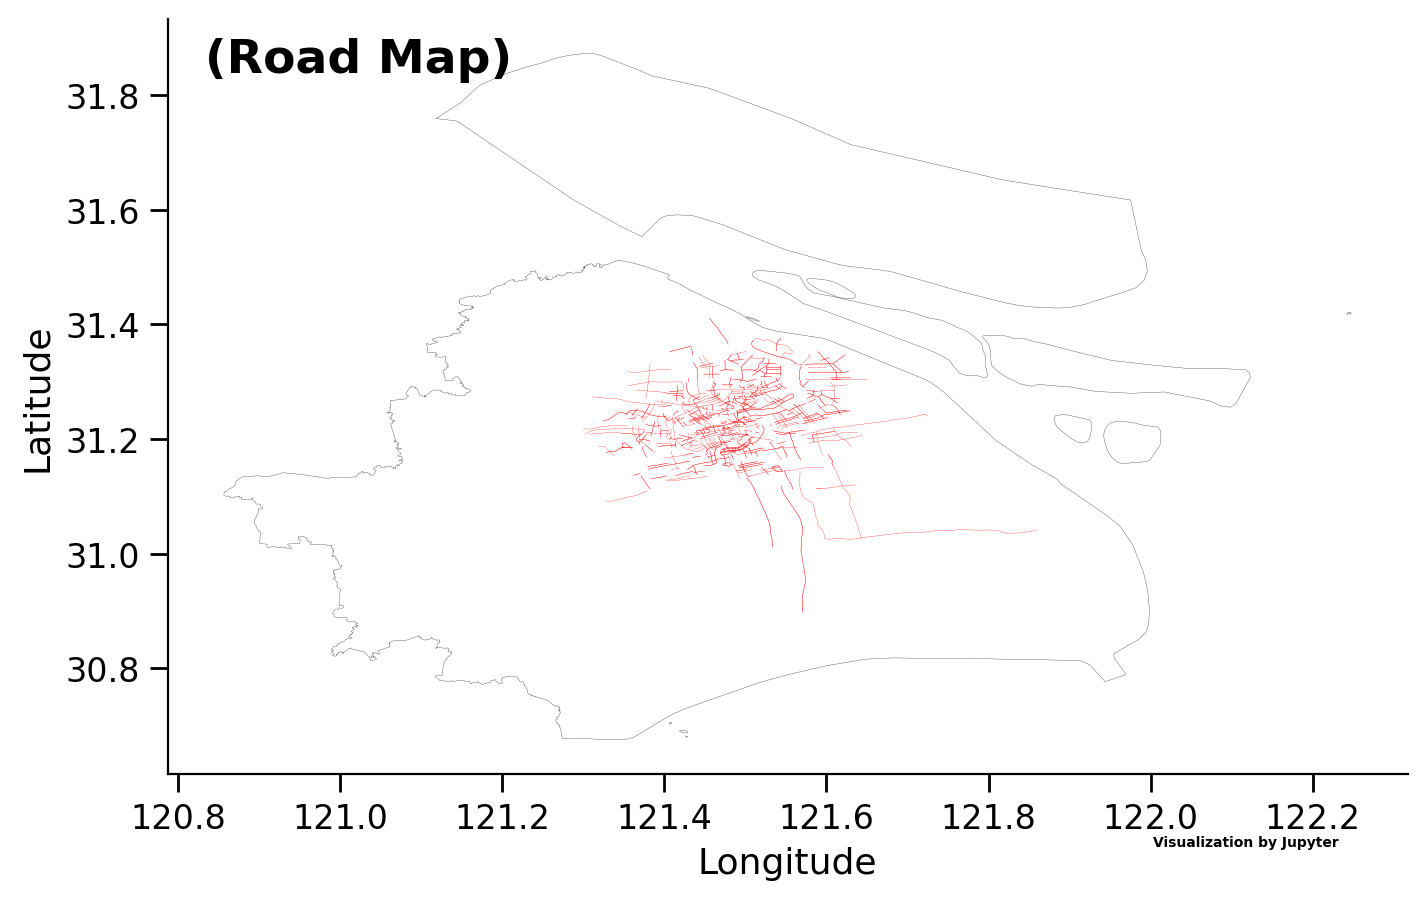

In [9]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
for line in sh_poly_lines:
    ax.plot(line[0],line[1],color='black',linewidth=.1)
for road in road_zip.keys():
    msg=road_dict[road]
    road_polyline=np.array(msg['polyline'])
    road_polyline=road_polyline.T
    ax.plot(road_polyline[0],road_polyline[1],color='r',linewidth=.1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Road Map)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

# 模式挖掘
## 构建图数据结构

In [11]:
#从道路方向信息中解析出道路的起讫点
def decode_direction(direction):
    begin,end='',''
    if direction[0]=='从':
        strlist=direction.split('到')
        begin=strlist[0][1:]
        end=strlist[1]
    elif direction[-2:]=='附近':
        begin=direction[:-2]
        end=direction[:-2]
    return begin,end
#vnodes的键是道路名，值是道路在邻接矩阵中的索引
vnodes={}
for road in road_zip.keys():
    begin,end=decode_direction(road[1])
    #将道路名加入到vnode集
    if road[0] not in vnodes:
        vnodes[road[0]]=len(vnodes)
    #将道路起点加入到vnode集
    if begin not in vnodes:
        vnodes[begin]=len(vnodes)
    #将道路终点加入到vnode集
    if end not in vnodes:
        vnodes[end]=len(vnodes)

#构建邻接矩阵
adj_matrix=[[0 for j in range(len(vnodes))] for i in range(len(vnodes))]

data=np.array(list(road_zip.values()))[:,:,0]
data=data.T
k=5    #k代表检查当前时间点之前kT范围内所有产生拥堵的路段
g=2    #g代表将当前道路向前追溯g代的祖先道路纳入检查范围
old_cjst_group=[[] for _ in range(k)]    #前kT时间段内曾经发生拥堵的道路集合，每个T各成一个列表
new_cjst=[]    #记录当前时间内发生拥堵的路段
#按照时间遍历
for Tdata in data:
    new_cjst=[]    #清空新拥堵道路集合
    old_cjst=[]    #构建历史拥堵道路集合
    for cjst in old_cjst_group:
        old_cjst.extend(cjst)
    #按照道路遍历
    for i,Rdata in enumerate(Tdata):
        #如果道路发生了拥堵
        if Rdata>=2:
            rname=list(road_zip.keys())[i][0]
            #将道路对应d 矩阵的环的值增加
            adj_matrix[vnodes[rname]][vnodes[rname]]+=Rdata
            #如果道路拥堵是新发生的
            if rname not in old_cjst:
                #通过广度优先遍历当前道路的g代祖先道路，并筛选出曾经拥堵的祖先道路
                tmp_vnodes=[rname]
                adj_vnodes=[]
                for _ in range(g):
                    new_tmp_vnodes=[]
                    while len(tmp_vnodes)>0:
                        tmp=tmp_vnodes.pop()
                        for road in road_zip.keys():
                            if road[0]==tmp:
                                begin,end=decode_direction(road[1])
                                if begin!=rname and begin not in adj_vnodes:
                                    adj_vnodes.append(begin)
                                    new_tmp_vnodes.append(begin)
                                if end!=rname and end not in adj_vnodes:
                                    adj_vnodes.append(end)
                                    new_tmp_vnodes.append(end)
                    tmp_vnodes=new_tmp_vnodes
                #每一个曾经拥堵的祖先道路都对当前道路施加影响，将对应的矩阵的边的值增加
                for adj in adj_vnodes:
                    adj_matrix[vnodes[adj]][vnodes[rname]]+=Rdata
            new_cjst.append(rname)
    #更新历史拥堵道路
    for i in range(1,k):
        old_cjst_group[i-1]=old_cjst_group[i]
    old_cjst_group[k-1]=new_cjst

#绘制矩阵
import cv2 as cv
sample=np.array(adj_matrix)
sample=np.int64(sample>0)
sample=255.0*sample
print(np.max(sample))
cv.imwrite("adj_matrix.png", sample)

255.0


True

## 挖掘并绘制拥堵关键道路

济阳路
天宝路
天宝路
阜新路
阜新路
彰武路
彰武路
东昌路
溧阳路
溧阳路
杨树浦路
杨树浦路
临平路
临平路
飞虹路
常熟路
常熟路
长乐路
长乐路
康定路
康定路
西康路
复兴东路
方浜中路
三牌楼路
三牌楼路
方浜中路


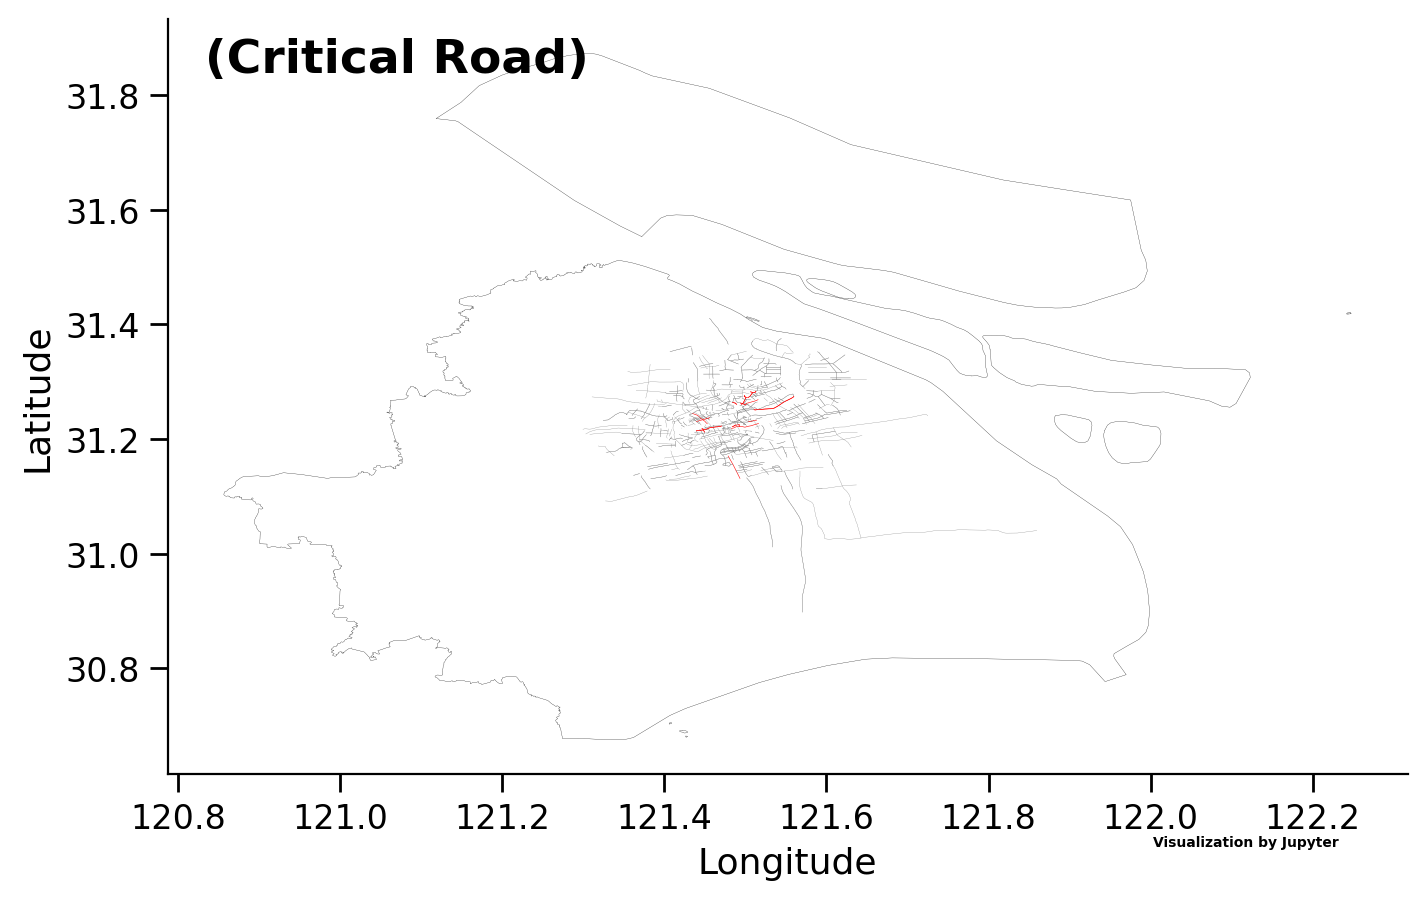

In [13]:
#将矩阵中值＞100的边筛选出来
influence={}
for i in range(len(adj_matrix)):
    for j in range(len(adj_matrix[i])):
        if i!=j and adj_matrix[i][j]>100:
            master,slave=list(vnodes.keys())[i],list(vnodes.keys())[j]
            if master in influence:
                influence[master].append((slave,adj_matrix[i][j]))
            else:
                influence[master]=[(slave,adj_matrix[i][j])]              

p=2#要求关键道路至少能影响到2条子孙道路
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
for line in sh_poly_lines:
    ax.plot(line[0],line[1],color='black',linewidth=.1)
for road in road_zip.keys():
    msg=road_dict[road]
    road_polyline=np.array(msg['polyline'])
    road_polyline=road_polyline.T
    if road[0] in influence and len(influence[road[0]])>=p:
        print(road[0])
        ax.plot(road_polyline[0],road_polyline[1],color='r',linewidth=.2)
    else:
        ax.plot(road_polyline[0],road_polyline[1],color='gray',linewidth=.1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Critical Road)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

# 统计分析
## 统计拥堵发生的时间特征

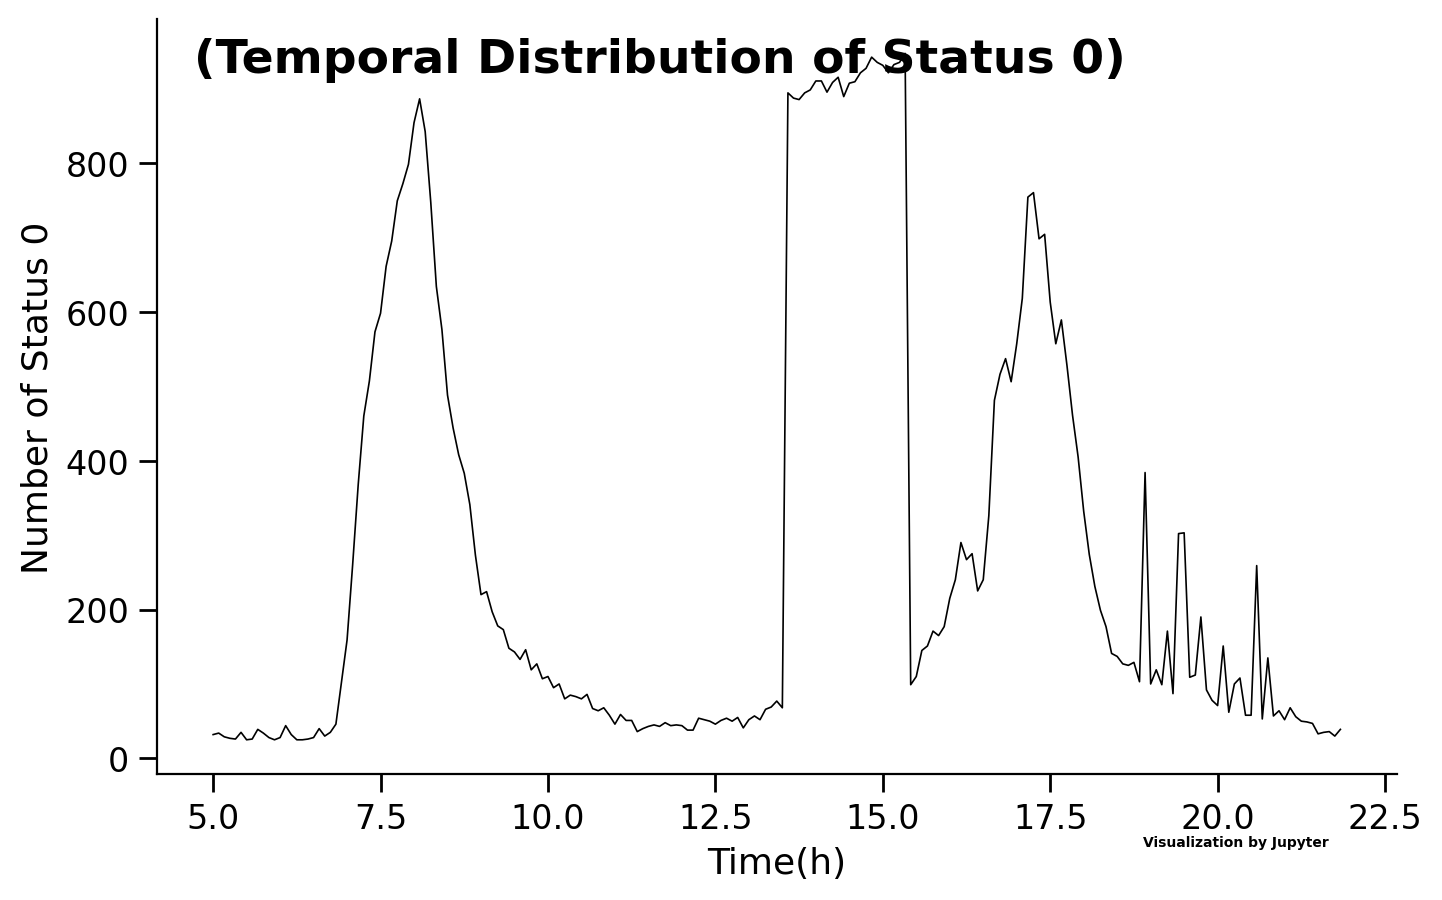

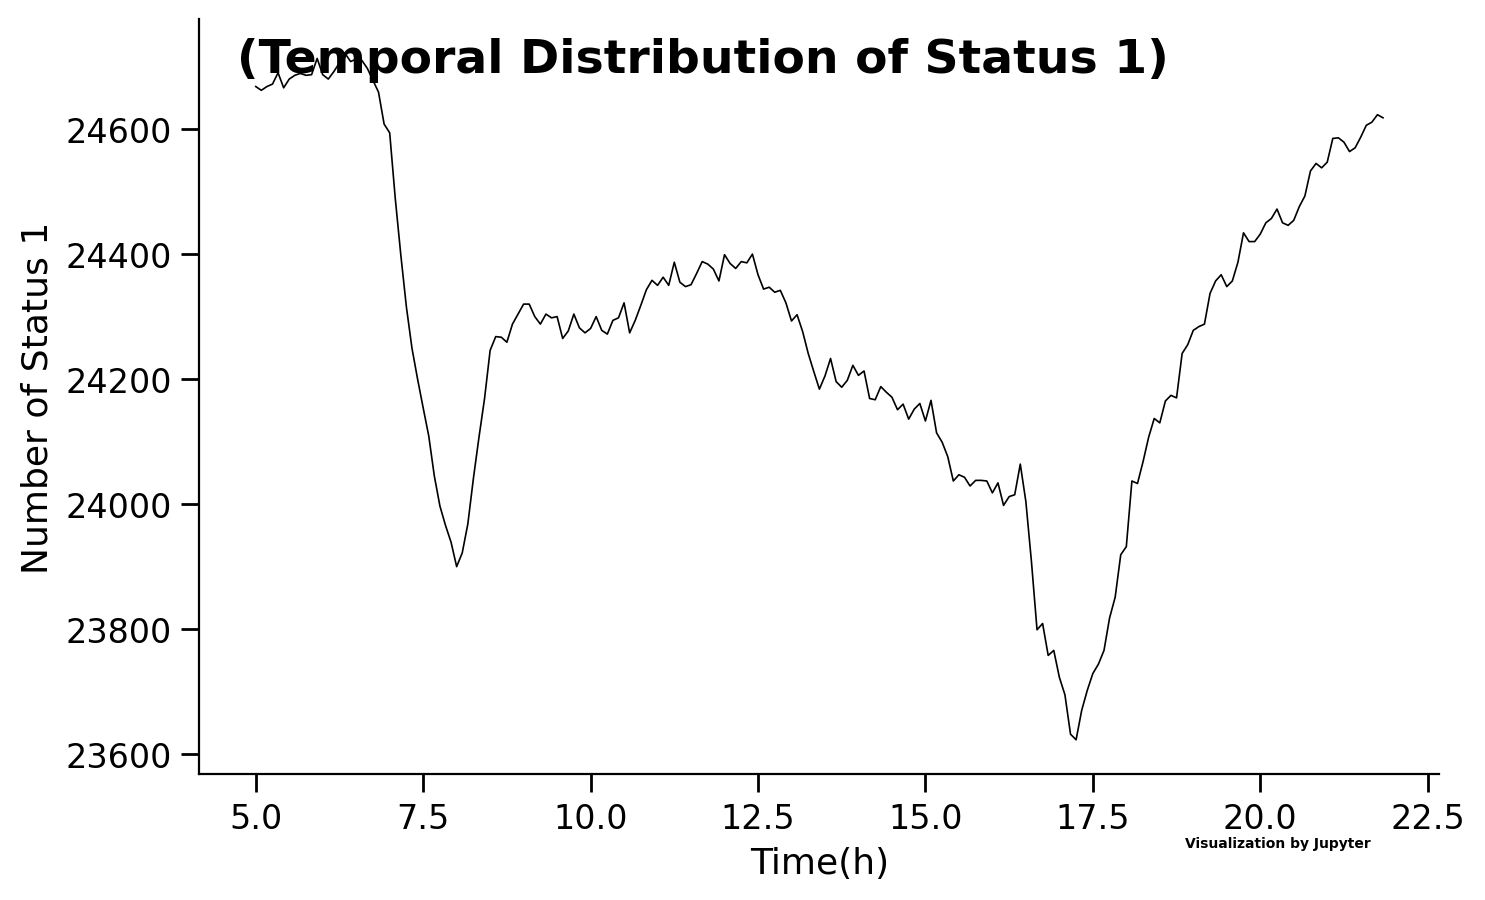

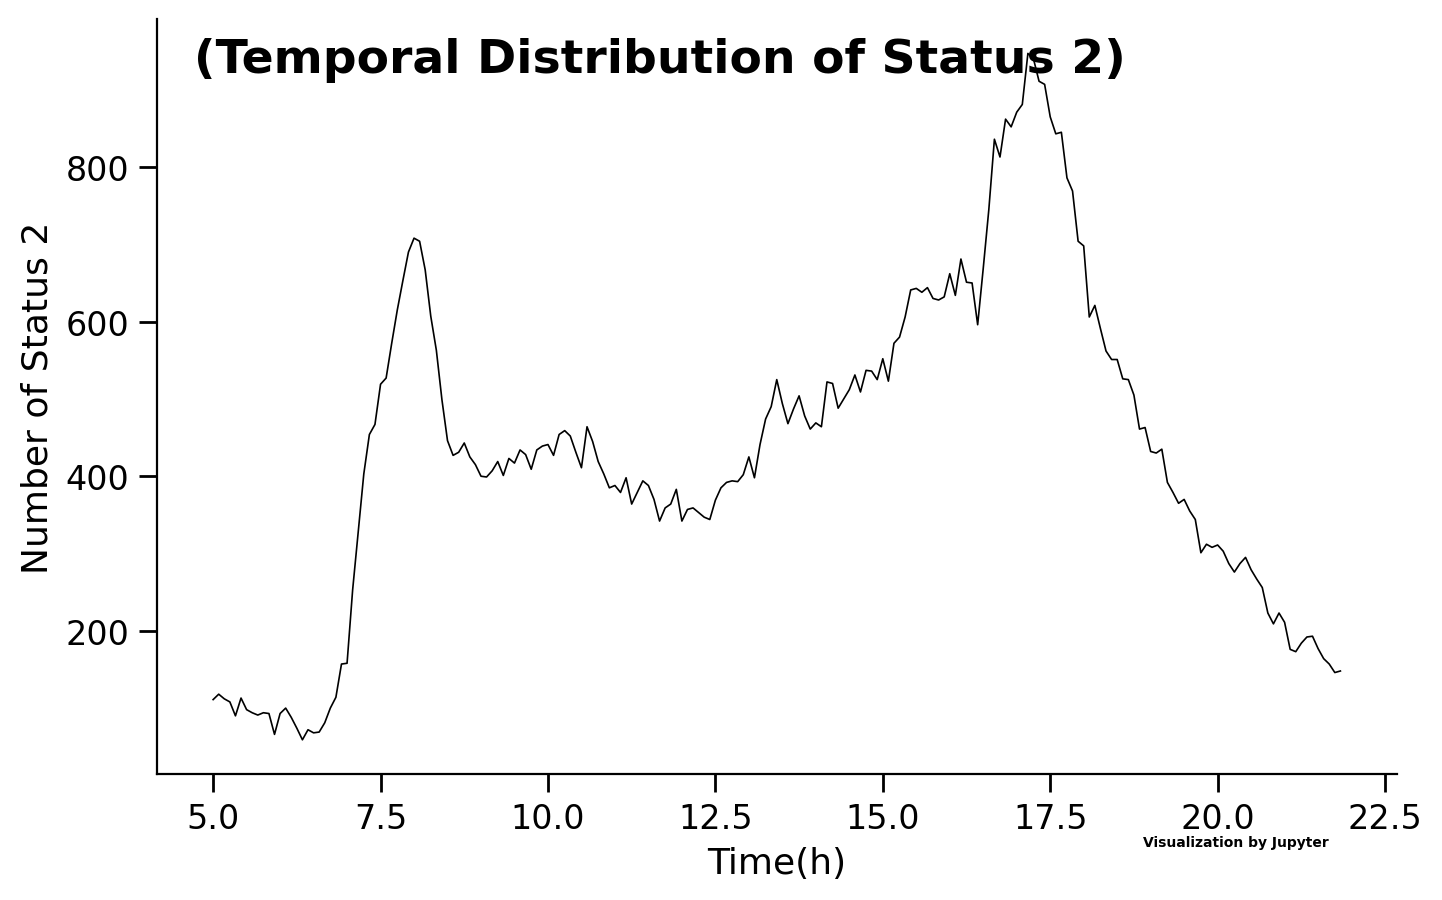

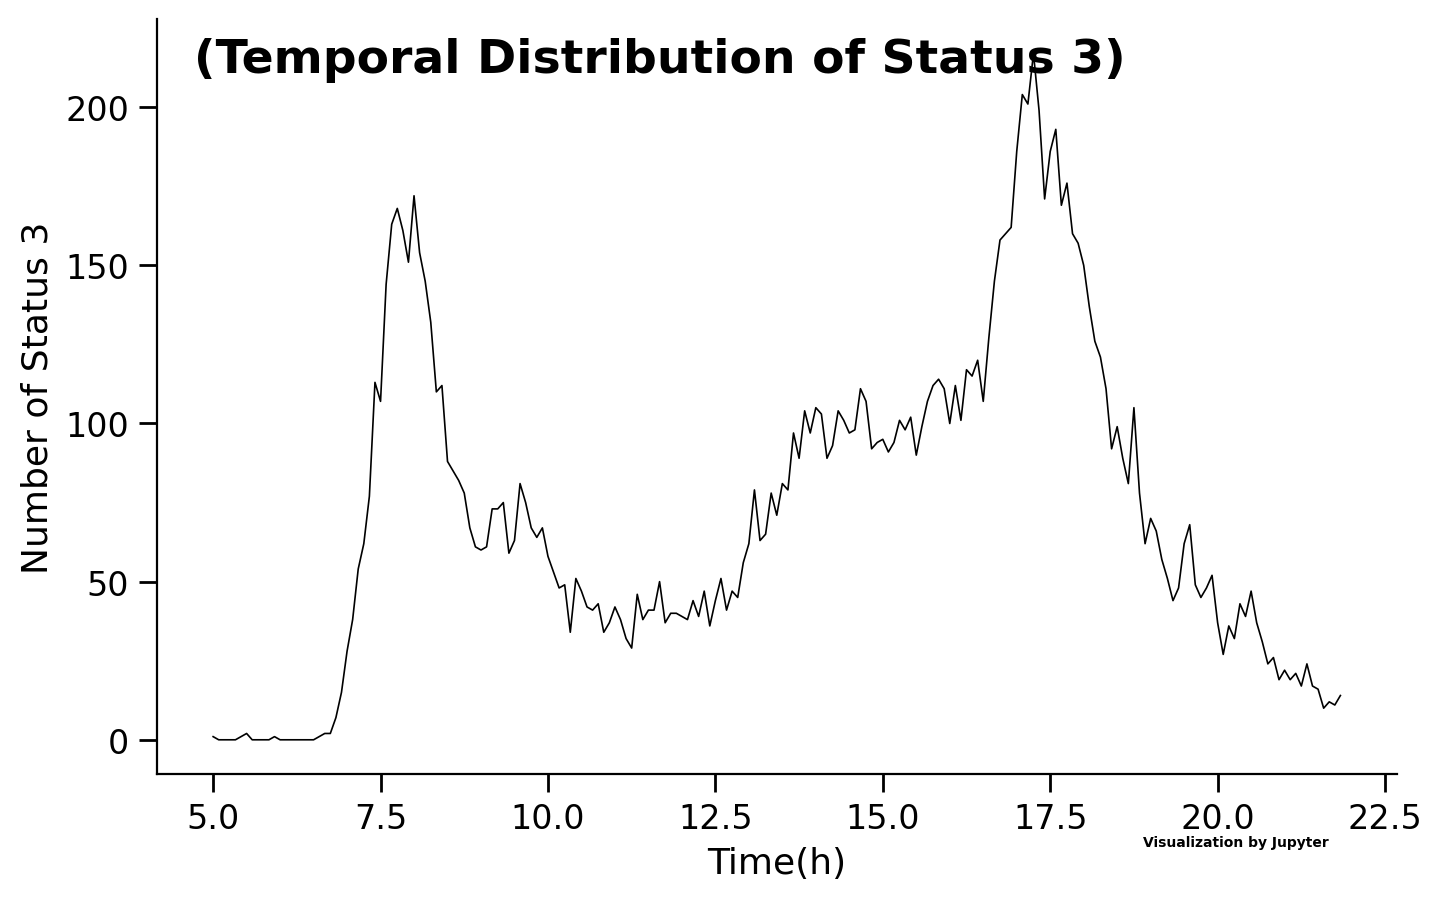

In [11]:
import matplotlib.pyplot as plt
data=np.array(list(road_zip.values()))[:,:,0]
data=data.reshape(-1,min_time_num)
data=data.T
result={0:[],1:[],2:[],3:[]}
for index,time_data in enumerate(data):
    cnt=Counter(time_data)
    for i in result:
        if i in cnt:
            result[i].append(cnt[i])
        else:
            result[i].append(0)
#把缺失值算作1（畅通）
result[1]=list(np.array(result[0])+np.array(result[1]))
label = [(i*5)/60+5 for i in range(len(result[0]))]
for index,value in result.items():
    fig,ax = plt.subplots(figsize=(8,5),dpi=200)
    ax.plot(label, value, color='black', linewidth=.6)
    ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(f'Number of Status {index}',fontsize=13)
    ax.set_xlabel('Time(h)',fontsize=13)
    text_font = {'size':'17','weight':'bold','color':'black'}
    ax.text(.03,.93,f'(Temporal Distribution of Status {index})',transform = ax.transAxes,fontdict=text_font,zorder=4)
    ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
    fig.show()


## 统计拥堵发生的持续时间特征


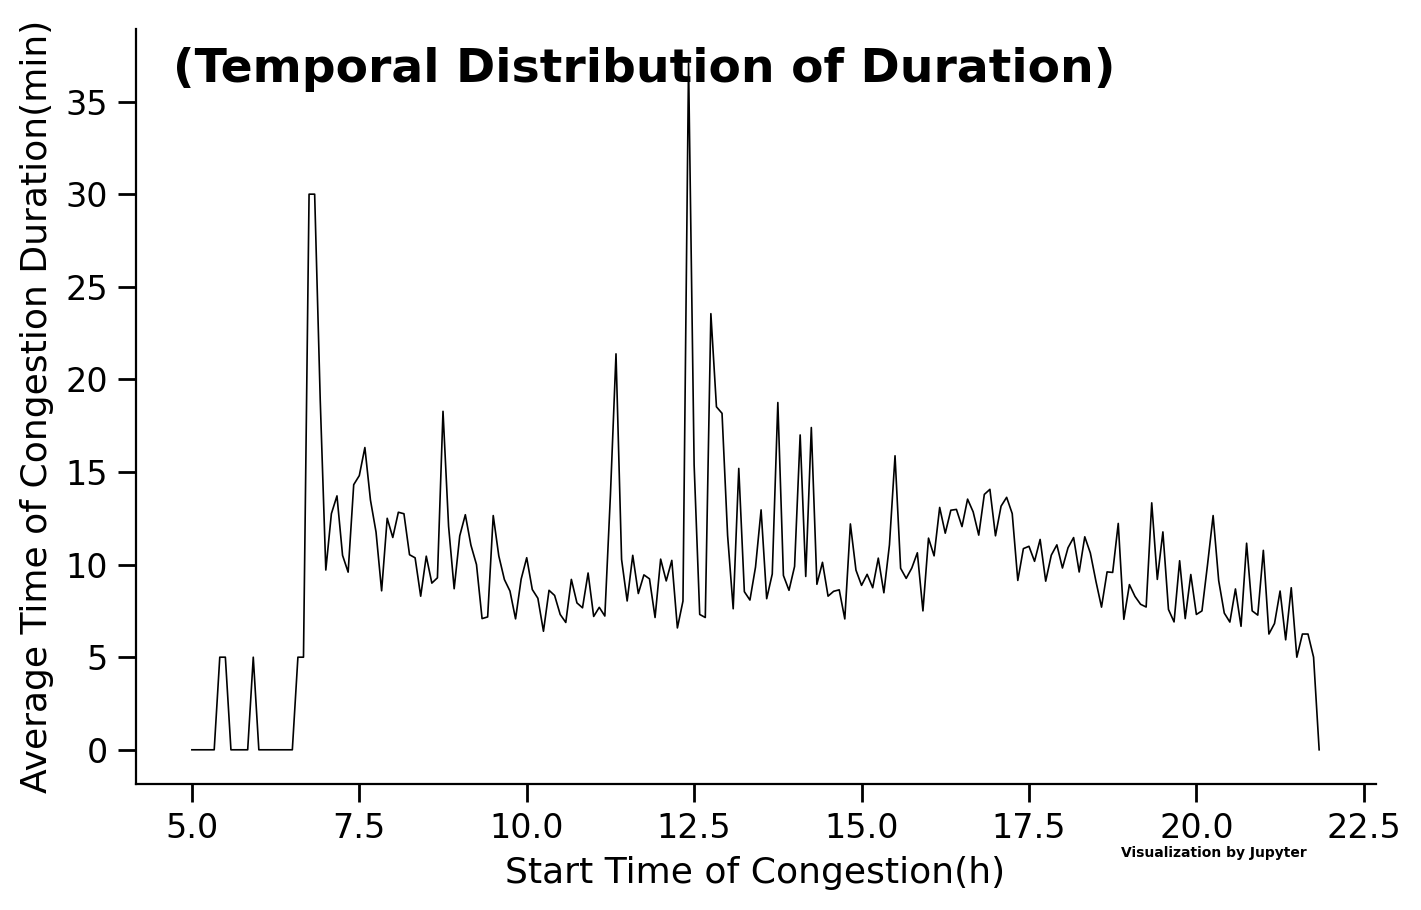

In [12]:
import matplotlib.pyplot as plt
data=np.array(list(road_zip.values()))[:,:,0]
data=data.reshape(data.shape[0],-1,min_time_num)

result=[]
for road in data:
    for date in road:
        start_time=0
        duration=0
        for index,item in enumerate(date):
            if start_time==0 and item>2:#统计拥堵等级为3的事件
                start_time=index
            if start_time!=0 and item<=2:
                duration=index-start_time
                #如果是range(1)则代表计算拥堵开始时刻的拥堵时间
                #如果是range(duration)则代表计算发生拥堵后每个时刻的拥堵时间
                for i in range(1):
                    result.append({'start_time':start_time+i,'duration':duration-i})
                start_time=0
                duration=0             
statistic={}
for item in result:
    if item['start_time'] in statistic:
        statistic[item['start_time']].append(item['duration'])
    else:
        statistic[item['start_time']]=[item['duration']]
avg_statistic=[]
for time_slice in range(min_time_num):
    if time_slice in statistic:
        avg_statistic.append(np.array(statistic[time_slice]).mean()*5)
    else:
        avg_statistic.append(0)

label = [(i*5)/60+5 for i in range(len(avg_statistic))]
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(label, avg_statistic, color='black', linewidth=.6)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Average Time of Congestion Duration(min)',fontsize=13)
ax.set_xlabel('Start Time of Congestion(h)',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Temporal Distribution of Duration)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

## 统计拥堵发生的空间特征

In [13]:
import math
import matplotlib.pyplot as plt
size=6#(size*5)^2 km^2
coord0=(121.475698,31.230428)
coord1=(coord0[0]-5*float(size/2)/(111.0*math.cos(coord0[1])),coord0[1]-5*float(size/2)/111.0)
coord2=(coord0[0]+5*float(size/2)/(111.0*math.cos(coord0[1])),coord0[1]+5*float(size/2)/111.0)
road_cgst_cnt={road:0 for road in road_zip.keys()}
for road,value in road_zip.items():
    for data in value:
        if data[0]>2:#统计拥堵等级为3的事件
            road_cgst_cnt[road]+=1
level=10#拥堵频率等级
min_cgst_cnt=min(road_cgst_cnt.values())
max_cgst_cnt=max(road_cgst_cnt.values())
unit=math.log(1+max_cgst_cnt-min_cgst_cnt)/level
road_cgst_statistic={i:[] for i in range(level+1)}
for road,cnt in road_cgst_cnt.items():
    lv=int(math.log(1+cnt-min_cgst_cnt)/unit)
    road_cgst_statistic[lv].append(list(road_dict[road]['location']))

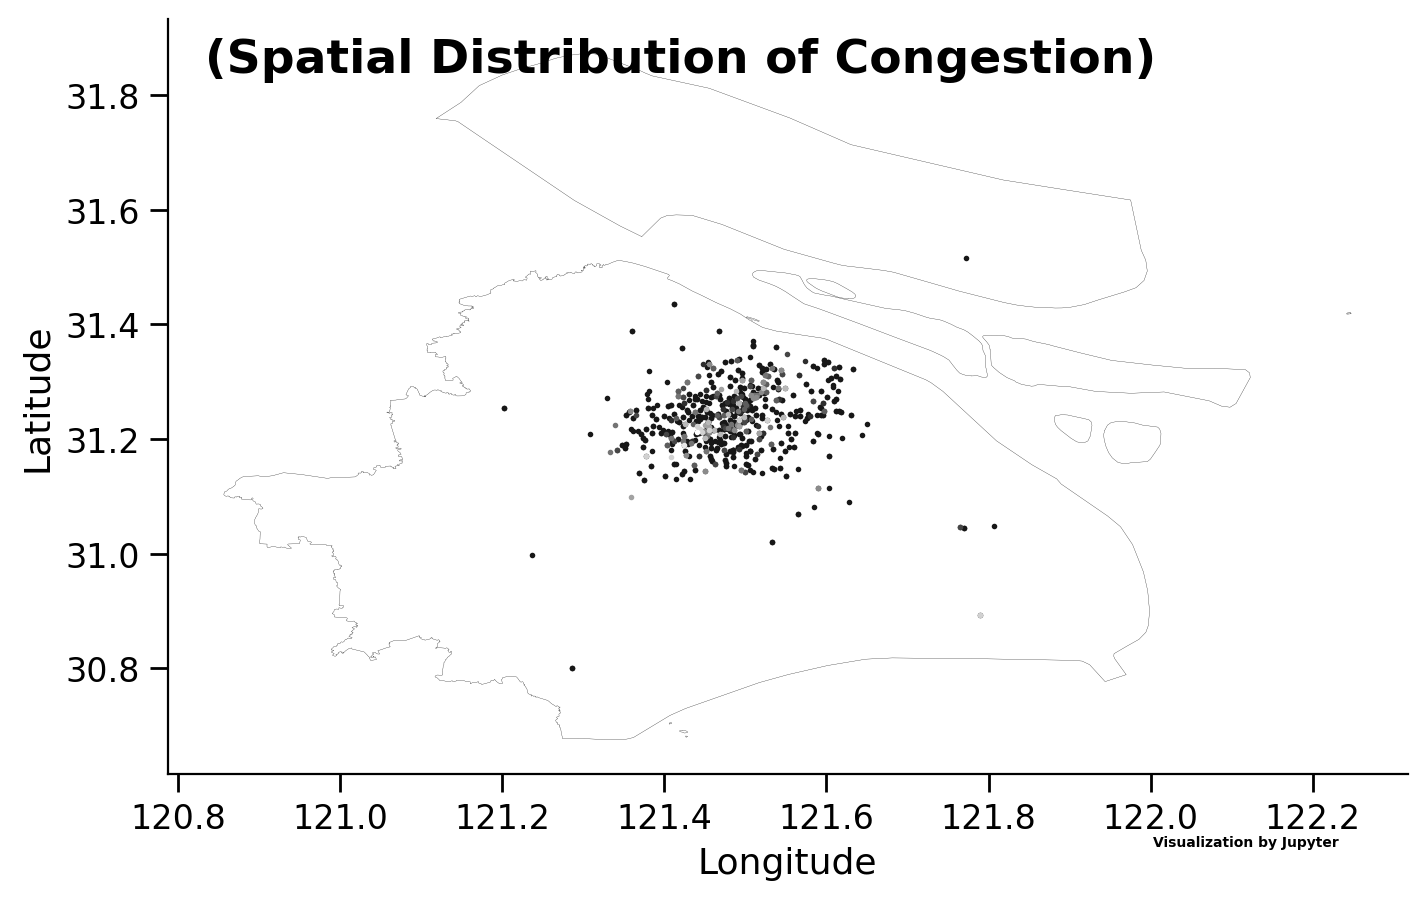

In [14]:
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
for line in sh_poly_lines:
    ax.plot(line[0],line[1],color='black',linewidth=.1)
for lv,points in road_cgst_statistic.items():
    if len(points)==0:
        continue
    np_points=np.array(points).T
    c=(lv+1)/(level+1)
    ax.scatter(np_points[0],np_points[1],color=(c,c,c),s=1)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Spatial Distribution of Congestion)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()